# FREDから経済データを取得+ベイズ時系列解析

In [1]:
using Distributed
addprocs(5)

5-element Array{Int64,1}:
 2
 3
 4
 5
 6

In [2]:
@everywhere using Mamba

In [3]:
using DataFrames
using Dates
using Distributions
using DotEnv
using HTTP
import ForneyLab.dot2svg
using JSON
using Plots
using Printf

[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/matsueushi/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


# 経済データの取得

In [4]:
DotEnv.config();

In [5]:
timeseries_url = @sprintf(
    "https://api.stlouisfed.org/fred/series/observations?series_id=%s&api_key=%s&file_type=json",
    "IPG2211A2N",
    ENV["FRED_API_KEY"])
r = HTTP.get(timeseries_url)

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Content-Type: application/json; charset=UTF-8
Server: Apache
Last-Modified: Wed, 27 Mar 2019 16:21:04 GMT
Expires: Mon, 01 Apr 2019 02:38:14 GMT
x-rate-limit-limit: 120
x-rate-limit-remaining: 120
Date: Mon, 01 Apr 2019 02:38:14 GMT
Transfer-Encoding: chunked
Connection: keep-alive, Transfer-Encoding

{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","observation_start":"1600-01-01","observation_end":"9999-12-31","units":"lin","output_type":1,"file_type":"json","order_by":"observation_date","sort_order":"asc","count":962,"offset":0,"limit":100000,"observations":[{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","date":"1939-01-01","value":"3.3842"},{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","date":"1939-02-01","value":"3.4100"},{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","date":"1939-03-01","value":"3.4875"},{"realtime_start":"2019-03-31","realtime_end":"2019-03-31","date":"1939-04-01","value":

In [6]:
obs_vec = JSON.parse(IOBuffer(r.body))["observations"]

962-element Array{Any,1}:
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-01-01","value"=>"3.3842")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-02-01","value"=>"3.4100")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-03-01","value"=>"3.4875")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-04-01","value"=>"3.5133")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-05-01","value"=>"3.5133")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-06-01","value"=>"3.5650")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-07-01","value"=>"3.5650")  
 Dict{String,Any}("realtime_start"=>"2019-03-31","realtime_end"=>"2019-03-31","date"=>"1939-08-01","value"=>"3.6167")  
 Dict{String,A

In [7]:
obs_df = DataFrame(permutedims(hcat(collect.(values.(obs_vec))...), (2, 1)), Symbol.(collect(keys(obs_vec[1]))))

962×4 DataFrame
│ Row │ realtime_start │ realtime_end │ date       │ value    │
│     │ String         │ String       │ String     │ String   │
├─────┼────────────────┼──────────────┼────────────┼──────────┤
│ 1   │ 2019-03-31     │ 2019-03-31   │ 1939-01-01 │ 3.3842   │
│ 2   │ 2019-03-31     │ 2019-03-31   │ 1939-02-01 │ 3.4100   │
│ 3   │ 2019-03-31     │ 2019-03-31   │ 1939-03-01 │ 3.4875   │
│ 4   │ 2019-03-31     │ 2019-03-31   │ 1939-04-01 │ 3.5133   │
│ 5   │ 2019-03-31     │ 2019-03-31   │ 1939-05-01 │ 3.5133   │
│ 6   │ 2019-03-31     │ 2019-03-31   │ 1939-06-01 │ 3.5650   │
│ 7   │ 2019-03-31     │ 2019-03-31   │ 1939-07-01 │ 3.5650   │
│ 8   │ 2019-03-31     │ 2019-03-31   │ 1939-08-01 │ 3.6167   │
│ 9   │ 2019-03-31     │ 2019-03-31   │ 1939-09-01 │ 3.7200   │
│ 10  │ 2019-03-31     │ 2019-03-31   │ 1939-10-01 │ 3.7200   │
⋮
│ 952 │ 2019-03-31     │ 2019-03-31   │ 2018-04-01 │ 93.4491  │
│ 953 │ 2019-03-31     │ 2019-03-31   │ 2018-05-01 │ 93.2405  │
│ 954 │ 2019-03-31     │ 2019-03-31   │ 2018-06-01 │ 103.3083 │
│ 955 │ 2019-03-31     │ 2019-03-31   │ 2018-07-01 │ 113.3178 │
│ 956 │ 2019-03-31     │ 2019-03-31   │ 2018-08-01 │ 113.2758 │
│ 957 │ 2019-03-31     │ 2019-03-31   │ 2018-09-01 │ 101.5656 │
│ 958 │ 2019-03-31     │ 2019-03-31   │ 2018-10-01 │ 95.3546  │
│ 959 │ 2019-03-31     │ 2019-03-31   │ 2018-11-01 │ 103.6453 │
│ 960 │ 2019-03-31     │ 2019-03-31   │ 2018-12-01 │ 113.2436 │
│ 961 │ 2019-03-31     │ 2019-03-31   │ 2019-01-01 │ 124.8584 │
│ 962 │ 2019-03-31     │ 2019-03-31   │ 2019-02-01 │ 116.0108 │

In [8]:
for x in [:realtime_start, :realtime_end, :date]
    obs_df[x] = Date.(obs_df[x] ,"y-m-d")
end
obs_df[:value] = parse.(Float64, obs_df[:value])

962-element Array{Float64,1}:
   3.3842
   3.41  
   3.4875
   3.5133
   3.5133
   3.565 
   3.565 
   3.6167
   3.72  
   3.72  
   3.7458
   3.7458
   3.7717
   ⋮     
 104.5716
  93.4491
  93.2405
 103.3083
 113.3178
 113.2758
 101.5656
  95.3546
 103.6453
 113.2436
 124.8584
 116.0108

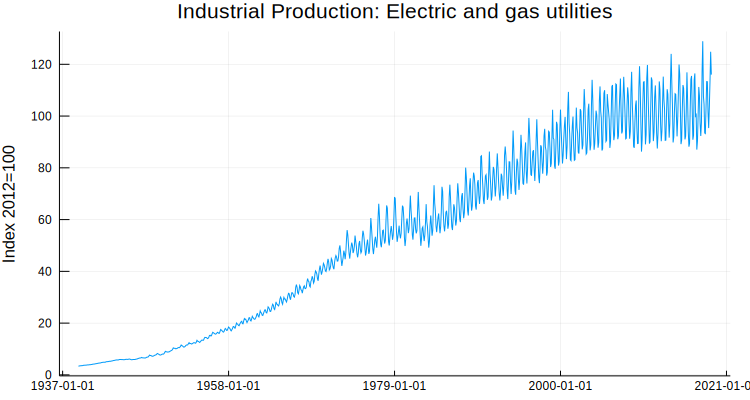

In [9]:
Plots.plot(obs_df[:date], obs_df[:value],
    size = [750, 400],
    title = "Industrial Production: Electric and gas utilities",
    ylabel = "Index 2012=100", 
    label = "")

全データを使うとフィッティングに時間がかかるので、2000年以降のデータを対象とする

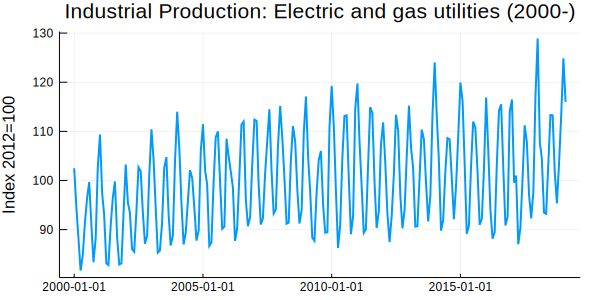

In [10]:
data_df = obs_df[obs_df[:date] .>= Date(2000,1,1), [:date, :value]]
Plots.plot(data_df[:date], data_df[:value],
    size = [600, 300],
    linewidth = 2,
    title = "Industrial Production: Electric and gas utilities (2000-)",
    ylabel = "Index 2012=100", 
    label = "")

# Bayesian Time Series Model
サンプルチェインの数

In [11]:
chains = 5

5

## Inverse Gamma vs Half Cauchy

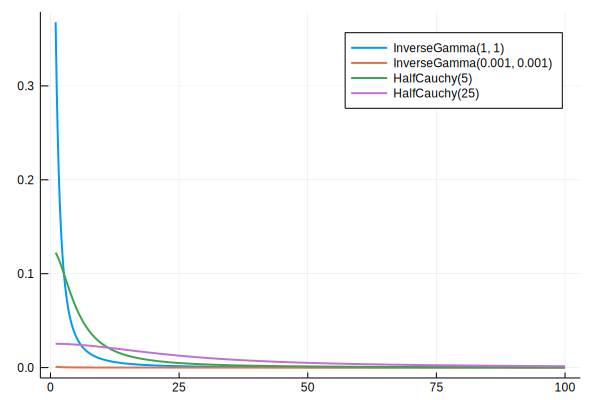

In [12]:
xs = 1:0.1:100
Plots.plot(xs, pdf.(InverseGamma(), xs), linewidth = 2, label = "InverseGamma(1, 1)")
Plots.plot!(xs, pdf.(InverseGamma(0.001, 0.001), xs), linewidth = 2, label = "InverseGamma(0.001, 0.001)")
Plots.plot!(xs, pdf.(Truncated(Cauchy(0, 5), 0, Inf), xs), linewidth = 2, label = "HalfCauchy(5)")
Plots.plot!(xs, pdf.(Truncated(Cauchy(0, 25), 0, Inf), xs), linewidth = 2, label = "HalfCauchy(25)")

## Local Level Model
\begin{align*}
y_t &= T_t + I_t, \\
T_{t+1} &= T_t + a_{T_i}, \\
I_t &\sim \mathcal{N}(0, \sigma_I^2), \\
a_{T_i} &\sim \mathcal{N}(0, \sigma_T^2)\\
T_0 &\sim \mathcal{N}(T_{init}, 100^2) \\
\end{align*}

In [13]:
local_level_model = Model(
    
    obs = Stochastic(1,
        (N, T, sigma_I) -> MvNormal(T, fill(sigma_I, N)),
        false
    ),
    
    T = Logical(1,
        (T_0, disturbance) -> T_0 .+ vcat([0], cumsum(disturbance)),
    ),
    
    disturbance = Stochastic(1,
        (N, sigma_T) -> MvNormal(N - 1, sigma_T),
        false
    ),
    
    sigma_I = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    sigma_T = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    
    T_0 = Stochastic(T_init -> Normal(T_init, 100)),
)

Object of type "Model"
-------------------------------------------------------------------------------
T:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
sigma_T:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_I:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
T_0:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
disturbance:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


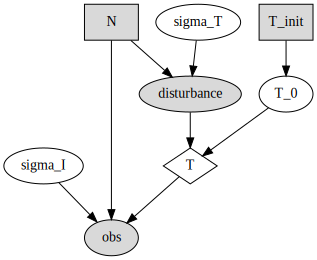

In [14]:
display("image/svg+xml", dot2svg(graph2dot(local_level_model)))

In [15]:
function sample_local_level_model()
    N = 100
    T_0 = rand(Normal(100, 100))
    sigma_I = rand(Truncated(Cauchy(0, 5), 0, Inf))
    sigma_T = rand(Truncated(Cauchy(0, 5), 0, Inf))
    disturbance = rand(MvNormal(N - 1, sigma_T))
    T = T_0 .+ vcat([0], cumsum(disturbance))
    obs = rand(MvNormal(T, fill(sigma_I, N)))
    
    Dict(
        :N => N,
        :T_0 => T_0,
        :sigma_I => sigma_I,
        :sigma_T => sigma_T,
        :disturbance => disturbance,
        :T => T,
        :obs => obs,
    )
end

sample_local_level_model (generic function with 1 method)

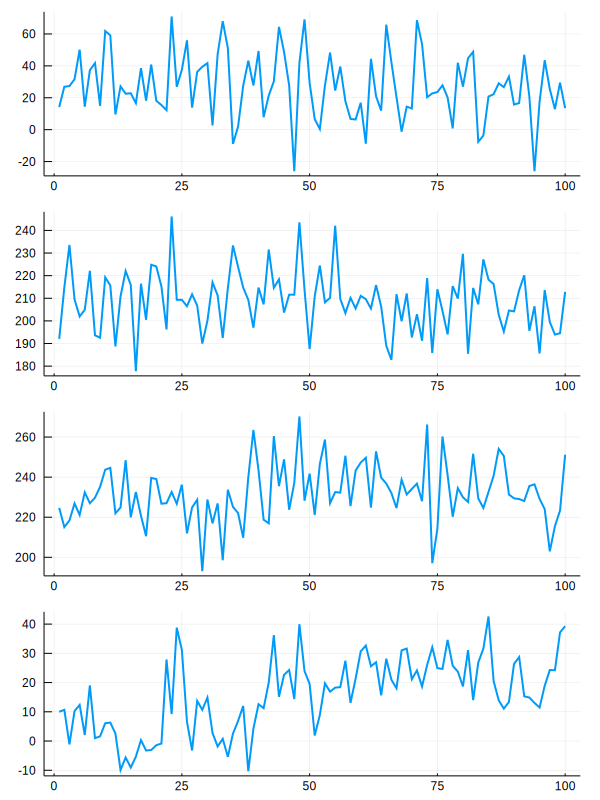

In [16]:
plts = []
for i in 1:4
    sample = sample_local_level_model()
    push!(plts, Plots.plot(sample[:obs], linewidth = 2, label = ""))
end
Plots.plot(plts..., layout = (4, 1), size = [600, 800])

### サンプルに対してフィッティング

In [17]:
local_level_sample = sample_local_level_model()

Dict{Symbol,Any} with 7 entries:
  :T           => [49.3584, 59.9654, 95.8342, 95.6399, 104.647, 103.784, 77.012…
  :N           => 100
  :sigma_I     => 25.4236
  :T_0         => 49.3584
  :sigma_T     => 22.2966
  :obs         => [20.1143, 28.7899, 51.3539, 88.2455, 108.616, 94.8128, 54.440…
  :disturbance => [10.6071, 35.8688, -0.194319, 9.00714, -0.862612, -26.772, 17…

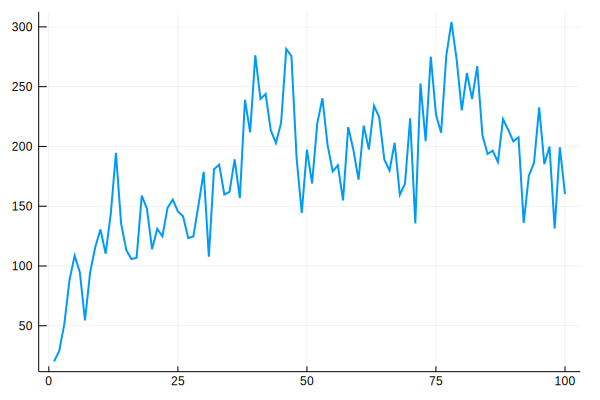

In [18]:
Plots.plot(local_level_sample[:obs], linewidth = 2, label = "")

In [19]:
local_level_sample_data = Dict(
    :obs => local_level_sample[:obs],
    :N => local_level_sample[:N],
    :T_init => local_level_sample[:obs][1],
)

Dict{Symbol,Any} with 3 entries:
  :N      => 100
  :T_init => 20.1143
  :obs    => [20.1143, 28.7899, 51.3539, 88.2455, 108.616, 94.8128, 54.4409, 94…

In [20]:
local_level_sample_inits = [
    Dict(
        :obs => local_level_sample_data[:obs],
        :T => local_level_sample_data[:obs],
        :disturbance => zeros(local_level_sample_data[:N] - 1),
        :sigma_I => 1,
        :sigma_T => 1,
        :T_0 => local_level_sample_data[:T_init],
    ) for _ in 1:chains
]

5-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[20.1143, 28.7899, 51.3539, 88.2455, 108.616, 94.8128, 54.4409, 94.7223, 115.872, 130.602  …  207.617, 135.984, 175.54, 186.231, 232.63, 185.196, 199.914, 131.347, 199.301, 160.207],:sigma_T=>1,:sigma_I=>1,:T_0=>20.1143,:obs=>[20.1143, 28.7899, 51.3539, 88.2455, 108.616, 94.8128, 54.4409, 94.7223, 115.872, 130.602  …  207.617, 135.984, 175.54, 186.231, 232.63, 185.196, 199.914, 131.347, 199.301, 160.207],:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Dict(:T=>[20.1143, 28.7899, 51.3539, 88.2455, 108.616, 94.8128, 54.4409, 94.7223, 115.872, 130.602  …  207.617, 135.984, 175.54, 186.231, 232.63, 185.196, 199.914, 131.347, 199.301, 160.207],:sigma_T=>1,:sigma_I=>1,:T_0=>20.1143,:obs=>[20.1143, 28.7899, 51.3539, 88.2455, 108.616, 94.8128, 54.4409, 94.7223, 115.872, 130.602  …  207.617, 135.984, 175.54, 186.231, 232.63, 185.196, 199.914, 131.347, 199.301, 160.207],:disturb

In [21]:
local_level_scheme = [
    AMWG([:disturbance], 1.0), Slice([:sigma_I, :sigma_T, :T_0], 1.0)
]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:disturbance]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Multivariate}}"
Sampling Block Nodes:
Symbol[:sigma_I, :sigma_T, :T_0]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                          

In [22]:
setsamplers!(local_level_model, local_level_scheme)
local_level_sample_sim = mcmc(
    local_level_model, local_level_sample_data, local_level_sample_inits, 
    21000, burnin = 1000, thin = 10, chains = chains)

MCMC Simulation of 21000 Iterations x 5 Chains...

      From worker 3:	Chain 3:   0% [4:07:46 of 4:07:53 remaining]
      From worker 2:	Chain 1:   0% [4:39:56 of 4:40:04 remaining]
      From worker 6:	Chain 2:   0% [4:08:27 of 4:08:34 remaining]
      From worker 4:	Chain 4:   0% [4:39:52 of 4:40:00 remaining]
      From worker 5:	Chain 5:   0% [5:10:40 of 5:10:49 remaining]
      From worker 3:	Chain 3:  10% [0:02:00 of 0:02:14 remaining]
      From worker 6:	Chain 2:  10% [0:02:01 of 0:02:15 remaining]
      From worker 2:	Chain 1:  10% [0:02:14 of 0:02:29 remaining]
      From worker 4:	Chain 4:  10% [0:02:10 of 0:02:24 remaining]
      From worker 5:	Chain 5:  10% [0:02:18 of 0:02:33 remaining]
      From worker 3:	Chain 3:  20% [0:01:15 of 0:01:34 remaining]
      From worker 2:	Chain 1:  20% [0:01:22 of 0:01:43 remaining]
      From worker 4:	Chain 4:  20% [0:01:20 of 0:01:39 remaining]
      From worker 6:	Chain 2:  20% [0:01:21 of 0:01:41 remaining]
      From worker 5:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3,4,5
Samples per chain = 2000

[29.513 12.5627 … 186.255 170.969; 29.0224 13.3845 … 189.399 179.881; … ; 23.4329 13.7033 … 169.798 162.2; 22.4718 13.6402 … 181.889 185.573]

[28.7478 10.6181 … 190.816 189.877; 30.5018 10.7864 … 191.222 181.463; … ; 30.1895 10.7687 … 162.294 141.69; 31.5228 10.7959 … 165.379 145.007]

[28.7405 8.59715 … 153.242 140.352; 28.6474 8.56301 … 168.549 156.483; … ; 26.2919 8.76869 … 179.196 166.203; 25.8575 8.98093 … 178.732 164.321]

[29.7673 9.37515 … 206.537 213.645; 28.5837 10.7269 … 198.59 203.466; … ; 26.4724 16.8322 … 180.647 183.56; 24.8185 17.7342 … 163.499 124.396]

[24.9348 13.2166 … 197.363 182.218; 24.733 12.3071 … 192.4 175.594; … ; 26.0384 16.3676 … 157.318 163.555; 25.44 16.4603 … 166.517 130.208]

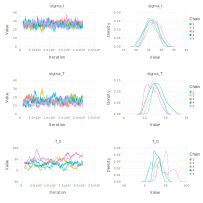

In [23]:
p = Mamba.plot(local_level_sample_sim[:, [:sigma_I, :sigma_T, :T_0], :], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

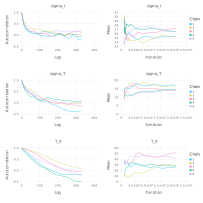

In [24]:
p = Mamba.plot(local_level_sample_sim[:, [:sigma_I, :sigma_T, :T_0], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

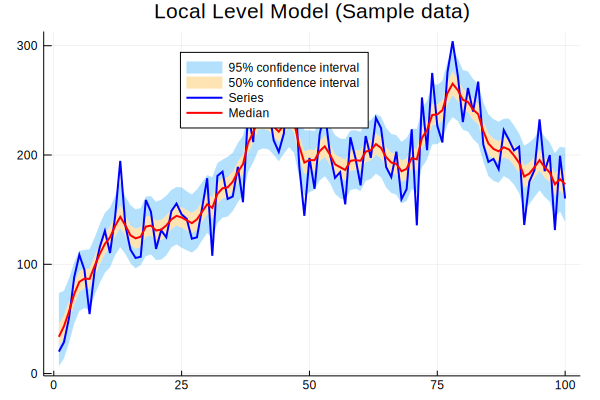

In [25]:
Ts = quantile(local_level_sample_sim[:, [:T], :]).value
Plots.plot(Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
Plots.plot!(Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
Plots.plot!(Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
Plots.plot!(local_level_sample[:obs],
    linewidth = 2, linecolor = :blue,
    title = "Local Level Model (Sample data)",
    label = "Series")
Plots.plot!(Ts[:, 3, :], 
    legend = :top,
    linewidth = 2, linecolor = :red, label = "Median")

### FREDから取得したデータに対してフィッティング

In [26]:
local_level_fred_data = Dict(
    :obs => data_df[:value],
    :N => size(data_df, 1),
    :T_init => data_df[:value][1],
)

Dict{Symbol,Any} with 3 entries:
  :N      => 230
  :T_init => 102.497
  :obs    => [102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99…

In [27]:
local_level_fred_inits = [
    Dict(
        :obs => local_level_fred_data[:obs],
        :T => local_level_fred_data[:obs],
        :disturbance => zeros(local_level_fred_data[:N] - 1),
        :sigma_I => 1,
        :sigma_T => 1,
        :T_0 => local_level_fred_data[:T_init],
    ) for _ in 1:chains
]

5-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:sigma_T=>1,:sigma_I=>1,:T_0=>102.497,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:sigma_T=>1,:sigma_I=>1,:T_0=>102.497,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:dis

In [28]:
local_level_fred_sim = mcmc(
    local_level_model, local_level_fred_data, local_level_fred_inits, 
    21000, burnin = 1000, thin = 10, chains = chains)

MCMC Simulation of 21000 Iterations x 5 Chains...

      From worker 6:	Chain 2:   0% [0:02:24 of 0:02:24 remaining]
      From worker 3:	Chain 1:   0% [0:03:37 of 0:03:37 remaining]
      From worker 5:	Chain 4:   0% [0:03:50 of 0:03:50 remaining]
      From worker 2:	Chain 3:   0% [0:04:29 of 0:04:29 remaining]
      From worker 4:	Chain 5:   0% [0:05:00 of 0:05:01 remaining]
      From worker 4:	Chain 5:  10% [0:02:35 of 0:02:52 remaining]
      From worker 6:	Chain 2:  10% [0:02:38 of 0:02:56 remaining]
      From worker 2:	Chain 3:  10% [0:02:40 of 0:02:57 remaining]
      From worker 5:	Chain 4:  10% [0:02:40 of 0:02:58 remaining]
      From worker 3:	Chain 1:  10% [0:02:41 of 0:02:59 remaining]
      From worker 5:	Chain 4:  20% [0:02:17 of 0:02:52 remaining]
      From worker 4:	Chain 5:  20% [0:02:22 of 0:02:57 remaining]
      From worker 6:	Chain 2:  20% [0:02:24 of 0:02:60 remaining]
      From worker 2:	Chain 3:  20% [0:02:24 of 0:03:00 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3,4,5
Samples per chain = 2000

[8.97928 0.61771 … 107.263 107.418; 9.05936 0.581417 … 108.541 107.898; … ; 8.93087 0.52265 … 107.157 106.753; 8.9376 0.500096 … 105.832 105.318]

[8.73271 0.620547 … 106.7 105.824; 8.89059 0.525728 … 109.527 110.215; … ; 9.21601 0.388972 … 106.342 106.096; 9.29202 0.353516 … 102.915 103.083]

[8.4465 1.42577 … 105.832 107.224; 8.8753 1.33702 … 108.149 106.277; … ; 8.86295 0.633136 … 104.85 105.466; 9.5606 0.682597 … 101.737 102.003]

[9.00163 0.424831 … 103.99 104.293; 8.93573 0.469707 … 103.915 103.802; … ; 8.90771 0.820317 … 106.246 105.267; 9.45765 0.905616 … 110.847 111.318]

[9.30755 0.55561 … 102.943 103.064; 9.44994 0.599103 … 104.525 104.196; … ; 9.3169 0.785458 … 103.198 103.434; 9.88417 0.784668 … 103.341 103.483]

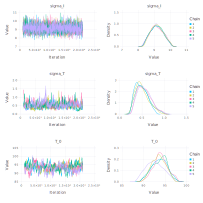

In [29]:
p = Mamba.plot(local_level_fred_sim[:, [:sigma_I, :sigma_T, :T_0], :], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

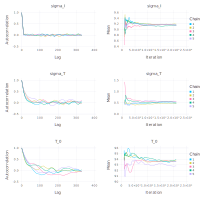

In [30]:
p = Mamba.plot(local_level_fred_sim[:, [:sigma_I, :sigma_T, :T_0], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

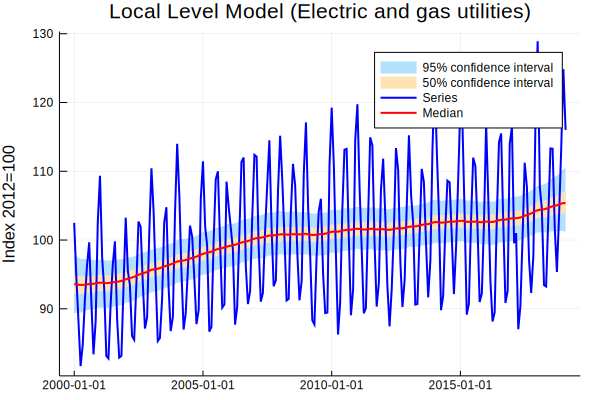

In [31]:
Ts = quantile(local_level_fred_sim[:, [:T], :]).value
Plots.plot(data_df[:date], Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
Plots.plot!(data_df[:date], data_df[:value],
    linewidth = 2, linecolor = :blue,
    title = "Local Level Model (Electric and gas utilities)",
    ylabel = "Index 2012=100", 
    label = "Series")
Plots.plot!(data_df[:date], Ts[:, 3, :], 
    linewidth = 2, linecolor = :red, label = "Median")

## Local Linear Model
\begin{align*}
y_t &= T_t + I_t, \\
T_{t+1} &= T_t + \beta_t + a_{T_i}, \\
\beta_{t+1} &= \beta_t + \zeta_t, \\
I_t &\sim \mathcal{N}(0, \sigma_I^2), \\
a_{T_i} &\sim \mathcal{N}(0, \sigma_T^2), \\
T_0 &\sim \mathcal{N}(T_{init}, 100^2), \\
\zeta_t &\sim \mathcal{N}(0, \sigma_\zeta^2), \\
\beta_0 &\sim \mathcal{N}(0, 10^2), \\
\end{align*}

In [32]:
local_linear_model = Model(
          
    obs = Stochastic(1,
        (N, T, sigma_I) -> MvNormal(T, fill(sigma_I, N)),
        false
    ),
    
    T = Logical(1,
        (T_0, beta, disturbance) -> T_0 .+ beta + vcat([0], cumsum(disturbance)),
    ),
    
    beta = Logical(1,
        (beta_0, zeta) -> beta_0 .+ vcat([0], cumsum(zeta)),
        false,
    ),
    
    disturbance = Stochastic(1,
        (N, sigma_T) -> MvNormal(N - 1, sigma_T),
        false
    ),
    
    zeta = Stochastic(1,
        (N, sigma_zeta) -> MvNormal(N - 1, sigma_zeta),
        false
    ),
    
    sigma_I = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    sigma_T = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    sigma_zeta = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    
    T_0 = Stochastic(T_init -> Normal(T_init, 100)),
    beta_0 = Stochastic(() -> Normal(0, 10)),
)

Object of type "Model"
-------------------------------------------------------------------------------
T:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
zeta:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
sigma_I:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_T:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_zeta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
T_0:
A monitored node of type 

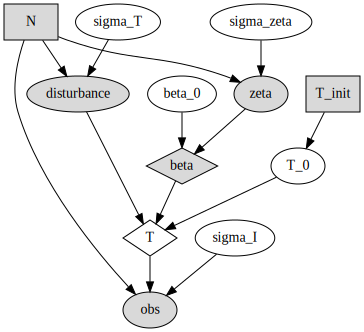

In [33]:
display("image/svg+xml", dot2svg(graph2dot(local_linear_model)))

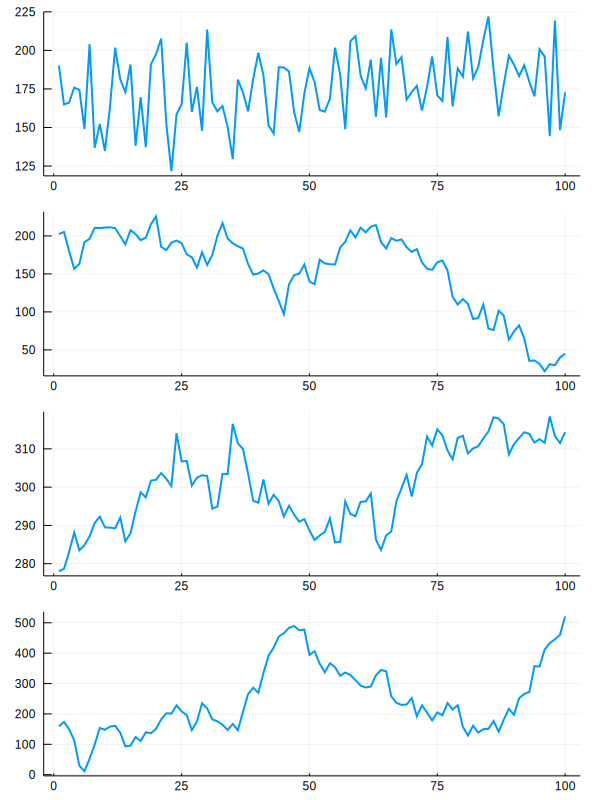

In [34]:
function sample_local_linear_model()
    N = 100
    
    T_0 = rand(Normal(100, 100))
    beta_0 = rand(Normal(0, 10))
    
    sigma_I = rand(Truncated(Cauchy(0, 5), 0, Inf))
    sigma_T = rand(Truncated(Cauchy(0, 5), 0, Inf))
    sigma_zeta = rand(Truncated(Cauchy(0, 5), 0, Inf))
    
    disturbance = rand(MvNormal(N - 1, sigma_T))
   
    zeta = rand(MvNormal(N - 1, sigma_zeta))
    beta = beta_0 .+ vcat([0], cumsum(zeta))
    T = T_0 .+ beta + vcat([0], cumsum(disturbance))
    
    obs = rand(MvNormal(T, fill(sigma_I, N)))
    
    Dict(
        :N => N,
        
        :T_0 => T_0,
        :beta_0 => beta_0,
        
        :sigma_I => sigma_I,
        :sigma_T => sigma_T,
        :sigma_zeta => sigma_zeta,
        
        :disturbance => disturbance,
        :T => T,
        :zeta => zeta,
        :beta => beta,
        
        :obs => obs,
    )
end

plts = []
for i in 1:4
    sample = sample_local_linear_model()
    push!(plts, Plots.plot(sample[:obs], linewidth = 2, label = ""))
end
Plots.plot(plts..., layout = (4, 1), size = [600, 800])

### サンプルデータへのフィッティング

In [35]:
local_linear_sample = sample_local_linear_model()

Dict{Symbol,Any} with 11 entries:
  :beta_0      => -4.97194
  :sigma_zeta  => 1.25443
  :N           => 100
  :zeta        => [1.20847, -1.12863, 0.44567, -0.512935, 1.79888, 0.825404, -0…
  :T_0         => 176.614
  :disturbance => [10.2565, 28.0343, -3.41283, 21.0647, 0.0708638, 6.36555, 52.…
  :T           => [171.642, 183.107, 210.013, 207.045, 227.597, 229.467, 236.65…
  :sigma_T     => 20.0741
  :sigma_I     => 2.50888
  :beta        => [-4.97194, -3.76347, -4.8921, -4.44643, -4.95936, -3.16048, -…
  :obs         => [171.136, 182.73, 209.217, 207.487, 229.491, 231.661, 237.309…

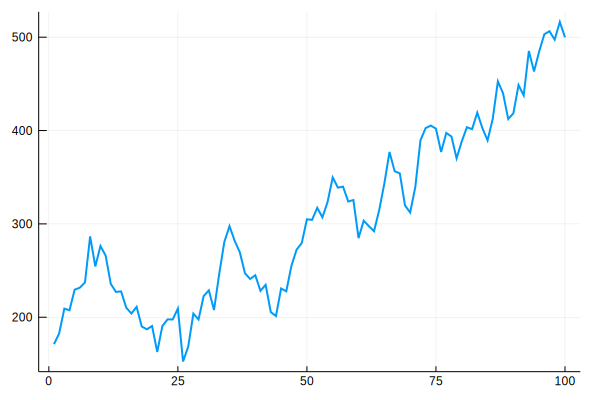

In [36]:
Plots.plot(local_linear_sample[:obs], linewidth = 2, label = "")

In [37]:
local_linear_sample_data = Dict(
    :obs => local_linear_sample[:obs],
    :N => local_linear_sample[:N],
    :T_init => local_linear_sample[:obs][1],
)

Dict{Symbol,Any} with 3 entries:
  :N      => 100
  :T_init => 171.136
  :obs    => [171.136, 182.73, 209.217, 207.487, 229.491, 231.661, 237.309, 286…

In [52]:
mean(diff(local_linear_sample_data[:obs]))

3.320600430477202

In [53]:
local_linear_sample_inits = [
    Dict(
        :obs => local_linear_sample_data[:obs],
        
        :T => local_linear_sample_data[:obs],
        :disturbance => zeros(local_linear_sample_data[:N] - 1),
        :beta => fill(mean(diff(local_linear_sample_data[:obs])), local_linear_sample_data[:N]),
        :zeta => zeros(local_linear_sample_data[:N] - 1),
        
        :sigma_I => 10,
        :sigma_T => 10,
        :sigma_zeta => 10,
        
        :T_0 => local_linear_sample_data[:T_init],
        :beta_0 => 0,
    ) for _ in 1:chains
]

5-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[171.136, 182.73, 209.217, 207.487, 229.491, 231.661, 237.309, 286.603, 254.422, 276.316  …  448.699, 437.646, 485.187, 463.306, 484.724, 503.181, 506.418, 497.36, 516.272, 499.875],:beta=>[3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206  …  3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206, 3.3206],:zeta=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:sigma_I=>10,:sigma_T=>10,:sigma_zeta=>10,:T_0=>171.136,:obs=>[171.136, 182.73, 209.217, 207.487, 229.491, 231.661, 237.309, 286.603, 254.422, 276.316  …  448.699, 437.646, 485.187, 463.306, 484.724, 503.181, 506.418, 497.36, 516.272, 499.875],:beta_0=>0,:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]…)
 Dict(:T=>[171.136, 182.73, 209.217, 207.487, 229.491, 231.661, 237.309, 286.603, 254.422, 276.316  …  448.699, 43

In [54]:
local_linear_scheme = [
    AMWG([:disturbance, :beta], 0.1), Slice([:T_0, :beta_0], 0.5),
    Slice([:sigma_I, :sigma_T, :sigma_zeta], 3.0)
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:disturbance, :beta]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Multivariate}}"
Sampling Block Nodes:
Symbol[:T_0, :beta_0]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 0.5), Const(##287#289{Bool,Float64}(false, 0.5), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                              

In [55]:
setsamplers!(local_linear_model, local_linear_scheme)
local_linear_sample_sim = mcmc(
    local_linear_model, local_linear_sample_data, local_linear_sample_inits, 
    21000, burnin = 1000, thin = 10, chains = chains)

MCMC Simulation of 21000 Iterations x 5 Chains...

      From worker 3:	Chain 3:   0% [0:01:39 of 0:01:39 remaining]
      From worker 2:	Chain 1:   0% [0:02:31 of 0:02:32 remaining]
      From worker 4:	Chain 4:   0% [0:02:35 of 0:02:35 remaining]
      From worker 5:	Chain 5:   0% [0:02:46 of 0:02:46 remaining]
      From worker 6:	Chain 2:   0% [0:03:30 of 0:03:30 remaining]
      From worker 2:	Chain 1:  10% [0:02:55 of 0:03:14 remaining]
      From worker 6:	Chain 2:  10% [0:04:39 of 0:05:10 remaining]
      From worker 4:	Chain 4:  10% [0:05:04 of 0:05:38 remaining]
      From worker 5:	Chain 5:  10% [0:05:06 of 0:05:40 remaining]
      From worker 3:	Chain 3:  10% [0:05:11 of 0:05:46 remaining]
      From worker 2:	Chain 1:  20% [0:03:32 of 0:04:25 remaining]
      From worker 3:	Chain 3:  20% [0:04:04 of 0:05:05 remaining]
      From worker 4:	Chain 4:  20% [0:04:08 of 0:05:10 remaining]
      From worker 6:	Chain 2:  20% [0:04:23 of 0:05:28 remaining]
      From worker 5:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3,4,5
Samples per chain = 2000

[61.8365 -17.051 … 414.246 417.455; 61.3781 -15.3539 … 413.901 417.375; … ; 16.5039 11.6706 … 499.91 510.173; 16.5039 11.6706 … 497.468 506.503]

[27.5487 3.41196 … 438.202 434.309; 27.5487 3.41196 … 437.169 433.407; … ; 74.1386 48.101 … 500.714 505.16; 74.1386 48.101 … 438.918 454.159]

[45.5589 19.0822 … 476.208 476.749; 45.5589 19.0822 … 476.106 476.361; … ; 124.844 -25.0658 … 478.312 487.234; 125.24 -34.9672 … 469.643 475.443]

[46.9746 6.61271 … 441.809 440.253; 46.9746 6.61271 … 448.925 448.096; … ; 4.56841 96.4958 … 518.014 493.64; 4.56841 96.4958 … 515.469 495.16]

[44.2908 9.67654 … 462.336 460.803; 44.2908 9.67654 … 469.003 467.757; … ; 16.2337 27.6461 … 499.369 506.274; 16.2337 27.6461 … 516.1 518.624]

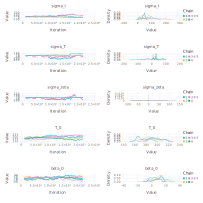

In [57]:
p = Mamba.plot(local_linear_sample_sim[:, [:sigma_I, :sigma_T, :sigma_zeta, :T_0, :beta_0], :], legend = true)
Mamba.draw(p, nrow = 5, ncol = 2)

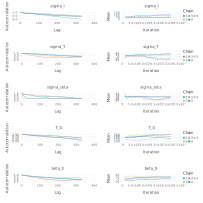

In [58]:
p = Mamba.plot(local_linear_sample_sim[:, [:sigma_I, :sigma_T, :sigma_zeta, :T_0, :beta_0], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 5, ncol = 2)

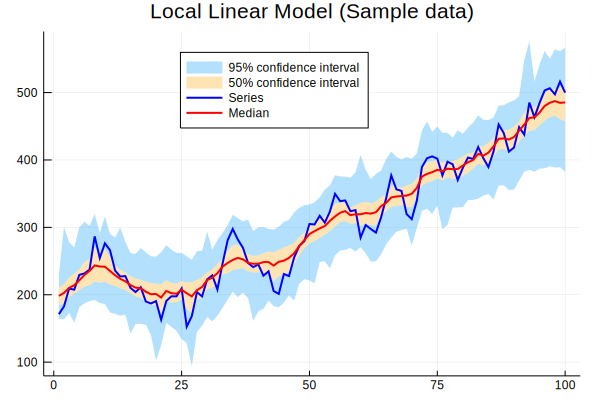

In [59]:
Ts = quantile(local_linear_sample_sim[:, [:T], :]).value
Plots.plot(Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
Plots.plot!(Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
Plots.plot!(Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
Plots.plot!(local_linear_sample[:obs],
    linewidth = 2, linecolor = :blue,
    title = "Local Linear Model (Sample data)",
    label = "Series")
Plots.plot!(Ts[:, 3, :], 
    legend = :top,
    linewidth = 2, linecolor = :red, label = "Median")

### FREDデータへのフィッティング

In [33]:
local_linear_fred_data = Dict(
    :obs => data_df[:value],
    :N => size(data_df, 1),
    :T_init => data_df[:value][1],
)

Dict{Symbol,Any} with 3 entries:
  :N      => 230
  :T_init => 102.497
  :obs    => [102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99…

In [34]:
local_linear_fred_inits = [
    Dict(
        :obs => local_linear_fred_data[:obs],
        
        :T => local_linear_fred_data[:obs],
        :disturbance => zeros(local_linear_fred_data[:N] - 1),
        :beta => zeros(local_linear_fred_data[:N]),
        :zeta => zeros(local_linear_fred_data[:N] - 1),
    
        :sigma_I => 1,
        :sigma_T => 1,
        :sigma_zeta => 1,
    
        :T_0 => local_linear_fred_data[:T_init],
        :beta_0 => 0
    ) for _ in 1:chains
]

5-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:beta=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:zeta=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:sigma_I=>1,:sigma_T=>1,:sigma_zeta=>1,:T_0=>102.497,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:beta_0=>0,:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]…)
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 

In [36]:
setsamplers!(local_linear_model, local_linear_scheme)
local_linear_fred_sim = mcmc(
    local_linear_model, local_linear_fred_data, local_linear_fred_inits, 
    21000, burnin = 1000, thin = 10, chains = chains)

MCMC Simulation of 21000 Iterations x 5 Chains...

      From worker 4:	Chain 4:   0% [0:15:22 of 0:15:23 remaining]
      From worker 5:	Chain 1:   0% [0:14:09 of 0:14:09 remaining]
      From worker 6:	Chain 3:   0% [0:17:20 of 0:17:20 remaining]
      From worker 3:	Chain 2:   0% [0:18:28 of 0:18:29 remaining]
      From worker 2:	Chain 5:   0% [0:19:12 of 0:19:12 remaining]
      From worker 5:	Chain 1:  10% [0:07:24 of 0:08:13 remaining]
      From worker 2:	Chain 5:  10% [0:07:47 of 0:08:39 remaining]
      From worker 6:	Chain 3:  10% [0:07:50 of 0:08:42 remaining]
      From worker 3:	Chain 2:  10% [0:07:53 of 0:08:46 remaining]
      From worker 4:	Chain 4:  10% [0:07:58 of 0:08:51 remaining]
      From worker 5:	Chain 1:  20% [0:06:37 of 0:08:16 remaining]
      From worker 3:	Chain 2:  20% [0:06:54 of 0:08:37 remaining]
      From worker 6:	Chain 3:  20% [0:06:57 of 0:08:42 remaining]
      From worker 4:	Chain 4:  20% [0:06:58 of 0:08:42 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3,4,5
Samples per chain = 2000

[8.76557 0.583095 … 0.00436592 -2.90727; 8.7697 0.63068 … 0.00418123 -3.90667; … ; 9.61274 0.473478 … 0.00411002 3.53956; 9.60849 0.483057 … 0.00409476 3.17041]

[7.75906 3.09269 … 0.00485756 -5.5504; 7.74154 3.10841 … 0.00447836 -8.22191; … ; 9.30602 0.592983 … 0.00482192 -7.49712; 9.33721 0.582747 … 0.00468498 -6.81298]

[8.33065 1.06788 … 0.00438088 -7.72969; 8.32999 1.04332 … 0.00421106 -7.58735; … ; 9.35755 0.684314 … 0.00430964 -10.1981; 9.37349 0.641415 … 0.00440653 -10.4555]

[8.46373 1.54343 … 0.00468742 -6.63696; 8.40701 1.55181 … 0.0045221 -9.65099; … ; 9.34735 0.306463 … 0.00441876 1.34508; 9.2856 0.287275 … 0.00404406 2.15221]

[8.16946 0.992454 … 0.00409742 -0.184271; 8.16344 0.981867 … 0.00427541 1.30811; … ; 8.64053 0.563806 … 0.00470644 21.8243; 8.77975 0.547439 … 0.00430486 20.3319]

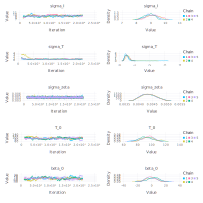

In [37]:
p = Mamba.plot(local_linear_fred_sim[:, [:sigma_I, :sigma_T, :sigma_zeta, :T_0, :beta_0], :], legend = true)
Mamba.draw(p, nrow = 5, ncol = 2)

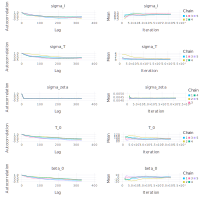

In [38]:
p = Mamba.plot(local_linear_fred_sim[:, [:sigma_I, :sigma_T, :sigma_zeta, :T_0, :beta_0], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 5, ncol = 2)

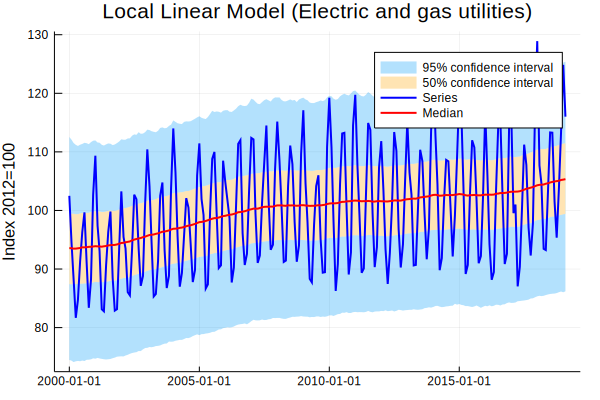

In [39]:
Ts = quantile(local_linear_fred_sim[:, [:T], :]).value
Plots.plot(data_df[:date], Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
Plots.plot!(data_df[:date], data_df[:value],
    linewidth = 2, linecolor = :blue,
    title = "Local Linear Model (Electric and gas utilities)",
    ylabel = "Index 2012=100", 
    label = "Series")
Plots.plot!(data_df[:date], Ts[:, 3, :], 
    linewidth = 2, linecolor = :red, label = "Median")

## Dummy Seasonal
さらに季節項$S_t$を導入する
\begin{align*}
y_t &= T_t + S_t + I_t, \\
T_{t+1} &= T_t + \beta_t + a_{T_i}, \\
\beta_{t+1} &= \beta_t + \zeta_t, \\
I_t &\sim \mathcal{N}(0, \sigma_I^2), \\
a_{T_i} &\sim \mathcal{N}(0, \sigma_T^2), \\
T_0 &\sim \mathcal{N}(T_{init}, 100^2), \\
\zeta_t &\sim \mathcal{N}(0, \sigma_\zeta^2), \\
\beta_0 &\sim \mathcal{N}(0, 10^2), \\
\end{align*}

ここで、季節項は
\begin{align*}
S_t &= - \sum_j^{11}S_{t-j} + \omega_t, \\
\omega_t &\sim \mathcal{N}(0, \sigma_\omega^2), \\
\end{align*}

### まず季節項だけのサンプルデータを作ってみる

In [54]:
using LinearAlgebra
N = 100

8

In [78]:
seas = rand(MvNormal(11, 3))
seas = vcat(seas, -sum(seas))
coef = repeat(Diagonal(ones(12)), N ÷ 12 + 1)[1:N, :]
seas_disturbance = cumsum(vcat(zeros(11), rand(MvNormal(N - 11, 1))))

100-element Array{Float64,1}:
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  0.0               
  1.221445770911381 
  0.7641054960947729
  ⋮                 
 -7.076566168967645 
 -6.145560995070067 
 -6.257983737482076 
 -6.066518582372617 
 -4.956150223977748 
 -4.191538978597539 
 -3.8110603499264437
 -1.9236356708255666
 -0.7239902579327202
 -1.0026938689279183
 -0.8212243189349051
 -1.6758364917875501

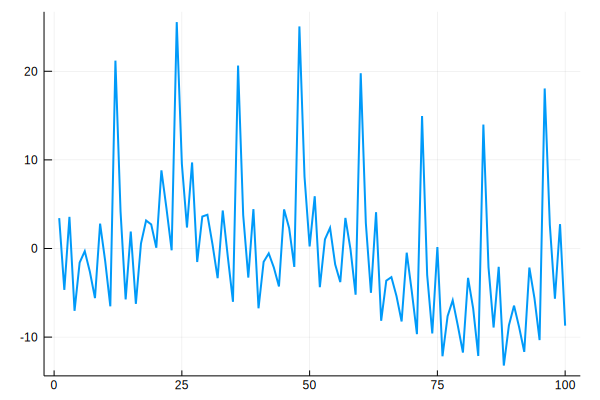

In [82]:
Plots.plot(coef * seas + seas_disturbance, linewidth = 2, label = "")

In [41]:
seasonal_model = Model(
    
    coef = Logical(1,
        N -> repeat(Diagonal(ones(12)), N ÷ 12 + 1)[1:N, :]
    ),
          
    obs = Stochastic(1,
        (T, beta, sigma_I) -> MvNormal(T + beta, fill(sigma_I, length(T))),
        false
    ),
    
    T = Logical(1,
        (T_0, disturbance) -> T_0 .+ vcat([0], cumsum(disturbance)),
    ),
    
    beta = Logical(1,
        (beta_0, zeta) -> beta_0 .+ vcat([0], cumsum(zeta)),
        false,
    ),
    
    disturbance = Stochastic(1,
        (N, sigma_T) -> MvNormal(N - 1, sigma_T),
        false
    ),
    
    zeta = Stochastic(1,
        (N, sigma_zeta) -> MvNormal(N - 1, sigma_zeta),
        false
    ),
    
    sigma_I = Stochastic(() -> InverseGamma()),
    sigma_T = Stochastic(() -> InverseGamma()),
    sigma_zeta = Stochastic(() -> InverseGamma()),
    
    T_0 = Stochastic(T_init -> Normal(T_init, 100)),
    beta_0 = Stochastic(() -> Normal(0, 10)),
)

Object of type "Model"
-------------------------------------------------------------------------------
T:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
zeta:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
sigma_I:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_T:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_zeta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
T_0:
A monitored node of type 